# Run deterministic model with injected synaptic noise for trial-trial variability


In [1]:
import custommodel as ctm
import deterministicfunc as dgi 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.optimize as scipyopti

# Select model and input to run

In [2]:
# ---- CHANNELS

# Main name for channels model to load
chanfile = 'carter_subtchan'

# List of models to tests: control, increased input resistance, etc
list_models= ['ctr','fdE0','ctrE0','fd']

# Action potential detection threshold
APthreshold = -20

# Ion conductance
iong = {'na':35, 'kdr':4, 'subchan':0.18} # mS/cm2 


# ---- INPUT

# Number of loops per synaptic input step
numloops = 800 

# Setup the input - p X rheo input
list_input0 = np.array(list(np.arange(70, 75, 1)/100)+list(np.arange(750, 1001, 5)/1000))
print(len(list_input0))

# Check if add synaptic noise - artificially creates trial-to-trial variability
# SET LEVEL FOR CONTROL ginput
syn_noise_sd = 4.5 # 0 = No added synaptic noise

# Ignored if no syn noise
compensate_noise = False # divide or not the stdev by the same as the mean



56


### Groups and parameters for the synaptic input

In [3]:
gl_drop = 0.79

modeldata = {'ctr':{'key_group':'ctr', 'gldrop': 1, 'clamprest': None}, 
             'fd':{'key_group':'fd', 'gldrop': gl_drop, 'clamprest': None}, 
             'fdE0':{'key_group':'ctr', 'gldrop': gl_drop, 'clamprest': None},
             'ctrE0':{'key_group':'fd', 'gldrop': 1, 'clamprest': None}}


In [4]:
palette = {'ctr':(0.4,0.4,0.4), 
           'fd': (0.2,0.2,1),
           'fdE0': (0.9,0,0.3), 
           'ctrE0': (0,0.7,0.35)}    

### Setup stimulus

In [5]:
stimdelay = 0
stimduration = 225 
intype = 'gsyn' # options: gsyn = conductance ; isyn = current synaptic input 

synparams = {'tau_rise':70, 'tau_decay':75,'Er':0, 'stimdelay':stimdelay, 'delay':0}
# note: 'delay' is an additional delay - see where insert synapse

stim_params = ctm.get_simginputparameters(stimdelay, stimduration, intype, synparams=synparams)

# Get rheo

In [6]:
isstochastic = False

if intype=='gsyn':
    precision = 1e-3
    offInput = 10
    onInput = 150
else:
    precision = 1e-6
    offInput = 0.1
    onInput = 10

gfirstspike_models = {}
model_params_models = {}

for model in list_models:
    
    print("*** "+model+" ***")
    
    model_params = ctm.ModelParameters(modeldata[model]['key_group'], isstochastic, 
                                       modeldata[model]['gldrop'], APthreshold, 
                                       chanfile=chanfile, iong=iong,  
                                       clamprest=modeldata[model]['clamprest'])

    dgi.check_setup_model_sim(model_params, stim_params)
    
    gfirstspike, _, is_success = dgi.get_firstspike_ginput(model_params,
                                                           stim_params,
                                                           offInput,
                                                           onInput,
                                                           precision)

    print(is_success)
    print(gfirstspike)
    
    gfirstspike_models[model] = gfirstspike
    
    # Save model
    model_params_models[model] = model_params

*** ctr ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.000 (sd)
True
54.425599999999996
*** fdE0 ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.0790 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.000 (sd)
True
42.9444
*** ctrE0 ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -70.0000 mV
	-Leak reversal potential -70.0000

### Get compensation

In [7]:
ref_model = 'ctr'

rcomp_models = {}

for model in list_models:
    
    print("*** "+model+" ***")
    
    rcomp_models[model] = gfirstspike_models[model] / gfirstspike_models[ref_model]
    

    print(rcomp_models[model])
    
 

*** ctr ***
1.0
*** fdE0 ***
0.7890478010348072
*** ctrE0 ***
0.8080241650987771
*** fd ***
0.6390301622765758


# Run Deterministic channels - with additional noise (conductance trial to trial var)

In [8]:
#doparallel = False
doparallel = True
#MAX_WORKERS = None # can leave like that if not doing multiproc
#MAX_WORKERS = os.cpu_count() # to use all ressources
MAX_WORKERS = 11 # select max number 


rec_var_models = {}

for model in list_models:
    
    print("*** "+model+" ***")


    # Add "syn noise"
    stim_params_synnoise = stim_params.copy()
    if syn_noise_sd>0:
        if compensate_noise:
            stim_params_synnoise['syn_noise_sd'] = syn_noise_sd/gfirstspike_models[ref_model]
        else:
            stim_params_synnoise['syn_noise_sd'] = syn_noise_sd/(rcomp_models[model]*gfirstspike_models[ref_model])

        # Norm noise to control so that we can simply * by amplitude to scale the noise
        # (see 'model_setup.py')
    
   
    dgi.check_setup_model_sim(model_params_models[model], stim_params_synnoise)
    


    # Setup the input
    list_input = list(rcomp_models[model]*gfirstspike_models[ref_model]*list_input0)
    
    rec_var_models[model] = dgi.run_io_ginput(model_params_models[model], stim_params_synnoise, 
                                              list_input, numloops, 
                                              doparallel=doparallel, chunksize=1, max_workers=MAX_WORKERS)
    


*** ctr ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.1000 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.083 (sd)
*** fdE0 ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -75.0000 mV
	-Leak reversal potential -75.0000 mV
	-Leak conductance 0.0790 mS/cm2
	-Capa 1.0000 uF/cm2
	-AP threshold -20.0000 mV
	-Total duration of stimulation 225.00 ms
	-Total duration of simulation 225.00 ms
	-Syn noise for trial variability 0.105 (sd)
*** ctrE0 ***
------------------------
Display model check...
	-Channels file: ch_carter_subtchan.ses
	-Resting potential and init E0 -70.0000 mV
	-Leak reversal potential -70.0000 mV
	-Leak conductance 0.1000 mS/cm2


# Get spike probability

In [9]:
p_spike_models = {}

for model, rec_var in rec_var_models.items():

    p_spike_models[model] = [sum([k>0 for k in u])/numloops for u in rec_var['apc']]
 

### Plot p spike vs input current/conductance

(0.7, 1.0)

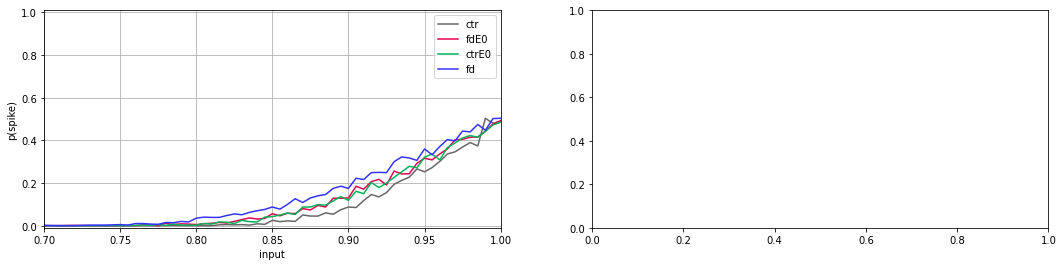

In [10]:
ylim = [-0.01,1.01]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

idx = 0
for model, p_spike in p_spike_models.items():

    ax[idx].plot(list_input0, p_spike, '-',color=palette[model], label=model)
    
ax[idx].set_xlabel('input')
ax[idx].set_ylabel('p(spike)')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)
ax[idx].set_xlim([0.7,1])


# Fit I/O

In [11]:
def genlogistic(x, b, slope, nu):
    return (1 + np.exp(-(x - b) / slope))**(-1/nu)

def get_p_genlogistic(p, b, slope, nu):
    return b - slope*np.log(p**(-nu)-1)


In [12]:
type(list_input0)

numpy.ndarray

In [13]:
# Note: test fit only until rheo!

lb = [0,0]
ub = [20,20]

popt_io_fit = {}

for model, p_spike in p_spike_models.items():
    
    popt_io_fit[model], pcov = scipyopti.curve_fit(genlogistic, list_input0, np.array(p_spike), 
                                     bounds=([list_input0[0]]+lb, 
                                             [list_input0[-1]]+ub))
    
    print(model)
    print(popt_io_fit[model])
   
    print('********')

ctr
[0.84345798 0.07281587 0.15581581]
********
fdE0
[0.73612995 0.09536677 0.08503325]
********
ctrE0
[0.71846491 0.09480129 0.06970153]
********
fd
[0.75862738 0.10547198 0.14178171]
********


/home/nrlab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


### Plot the fit

(-0.01, 0.2)

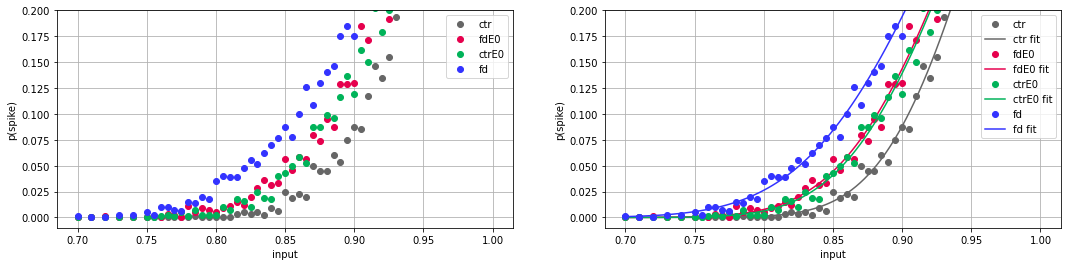

In [50]:
ylim = [-0.01,1.01]
ylim = [-0.01,0.2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

idx = 0
for model, p_spike in p_spike_models.items():

    ax[idx].plot(list_input0, p_spike, 'o',color=palette[model], label=model)
    
ax[idx].set_xlabel('input')
ax[idx].set_ylabel('p(spike)')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)
#ax[idx].set_xlim([1.75,2.5])
#ax[idx].set_ylim([0,0.3])


x0 = np.linspace(0.7, 1, num=100, endpoint=True)


idx = 1
for model, p_spike in p_spike_models.items():

    ax[idx].plot(list_input0, p_spike, 'o',color=palette[model], label=model)
    ax[idx].plot(x0, genlogistic(x0, *popt_io_fit[model]), '-',color=palette[model], label=model+" fit")
    #ax[idx].plot(x0, ioexp(x0, *popt_io_fit[model]), '-',color=palette[model], label=model+" fit")
    
    
    
ax[idx].set_xlabel('input')
ax[idx].set_ylabel('p(spike)')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)
#ax[idx].set_xlim([0.7,1])


    

### Plot I/O fit + norm

(-0.01, 1.01)

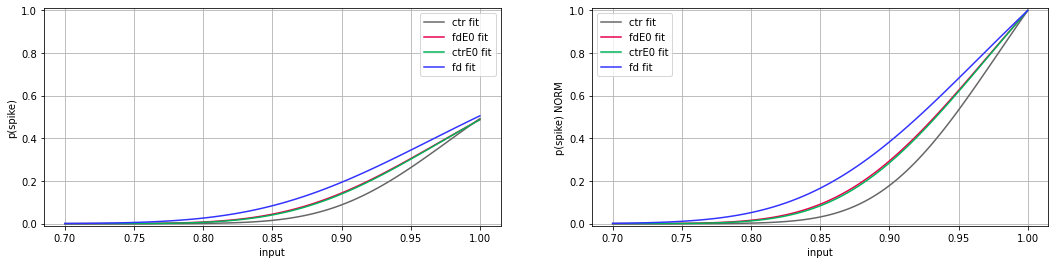

In [52]:
ylim = [-0.01,1.01]

#ylim = [-0.01,0.5]

x0 = np.linspace(0.7, 1, num=100, endpoint=True)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

idx = 0
for model, p_spike in p_spike_models.items():

    ax[idx].plot(x0, genlogistic(x0, *popt_io_fit[model]), '-',color=palette[model], label=model+" fit")
    

ax[idx].set_xlabel('input')
ax[idx].set_ylabel('p(spike)')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)
#ax[idx].set_xlim([0.7,1])


idx = 1
for model, p_spike in p_spike_models.items():

    pmax = genlogistic(1, *popt_io_fit[model])
    ax[idx].plot(x0, genlogistic(x0, *popt_io_fit[model])/pmax, '-',color=palette[model], label=model+" fit")
    

ax[idx].set_xlabel('input')
ax[idx].set_ylabel('p(spike) NORM')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)
#ax[idx].set_xlim([0.7,1])


# Setup Gaussian tuning curve

In [21]:
"""def gaussprofile(x, A, mu, sigma, C):
    return C + A*np.exp(-(x-mu)**2/(2.*sigma**2))"""

def gaussprofile(x, A, sigma):
    return A*np.exp(-x**2/(2.*sigma**2))

def gaussprofile_simple(x,sigma):
    return np.exp(-x**2/(2.*sigma**2))

In [22]:
theta_step = 1
list_theta = [theta-90 for theta in range(0,180+theta_step,theta_step)]

g_A = 0.9
g_sigma = 170

list_inputdata = [gaussprofile(theta, g_A, g_sigma)
                  for theta in list_theta]

### Plot input tuning curve

(0.5, 1.01)

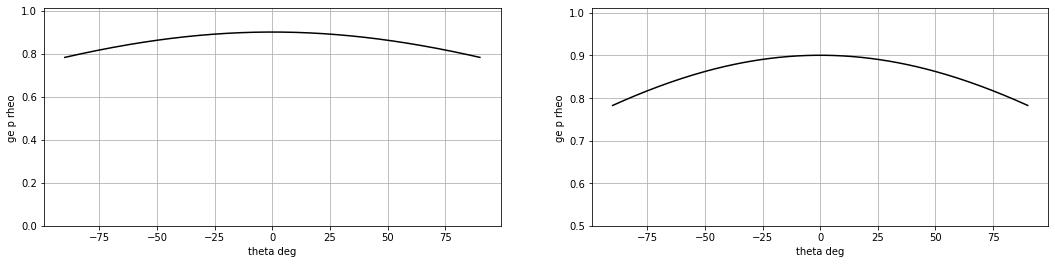

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

ylim = [0,1.01]
idx = 0
ax[idx].plot(list_theta, list_inputdata, '-',color='k')
    
ax[idx].set_xlabel('theta deg')
ax[idx].set_ylabel('ge p rheo')
ax[idx].grid()
ax[idx].set_ylim(ylim)


ylim = [0.5,1.01]
idx = 1
ax[idx].plot(list_theta, list_inputdata, '-',color='k')
    
ax[idx].set_xlabel('theta deg')
ax[idx].set_ylabel('ge p rheo')
ax[idx].grid()
ax[idx].set_ylim(ylim)

### Plot tuning curve spike output

In [ ]:
# FIT

lb = [0]
ub = [180]

popt_tc_fit = {}

for model in p_spike_models.keys():
    
    res = genlogistic(np.array(list_inputdata), *popt_io_fit[model])
    
    popt_tc_fit[model], pcov = scipyopti.curve_fit(gaussprofile_simple, list_theta, res/max(res), 
                                     bounds=(lb,ub))

    print(model)
    print(popt_tc_fit[model])
   
    print('********')
    
print([popt_tc_fit[model][0]/popt_tc_fit['ctr'][0] for model in popt_tc_fit.keys()])


(-0.01, 1.01)

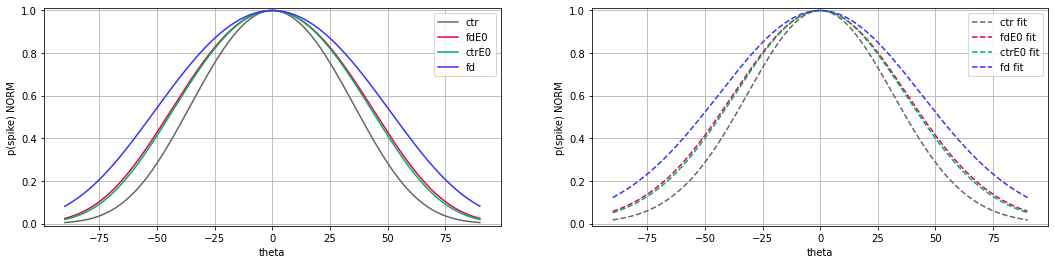

In [25]:
ylim = [-0.01,1.01]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

idx = 0
for model in p_spike_models.keys():

    res = genlogistic(np.array(list_inputdata), *popt_io_fit[model])
    ax[idx].plot(list_theta, res/max(res), '-',color=palette[model], label=model)
    

ax[idx].set_xlabel('theta')
ax[idx].set_ylabel('p(spike) NORM')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)



# FIT

idx = 1
for model in p_spike_models.keys():

    
    ax[idx].plot(list_theta, gaussprofile_simple(np.array(list_theta),*popt_tc_fit[model]), 
                 '--',color=palette[model], label=model+" fit")
    

ax[idx].set_xlabel('theta')
ax[idx].set_ylabel('p(spike) NORM')
ax[idx].grid()
ax[idx].legend()
ax[idx].set_ylim(ylim)

# CV

In [16]:
key_vm = 'vh'
vm_XX_std_models = {}
vm_XX_avg_models = {}
cv_XX_models = {}

for model, rec_var in rec_var_models.items():
    
    vm_XX_std_models[model] = [np.std(v_list) for v_list in rec_var_models[model][key_vm]]
    vm_XX_avg_models[model] = [np.mean(v_list) for v_list in rec_var_models[model][key_vm]]
    
    
    cv_XX_models[model] = [s/(v-model_params_models[model].E0) for 
                           s,v in zip(vm_XX_std_models[model],vm_XX_avg_models[model])]
    


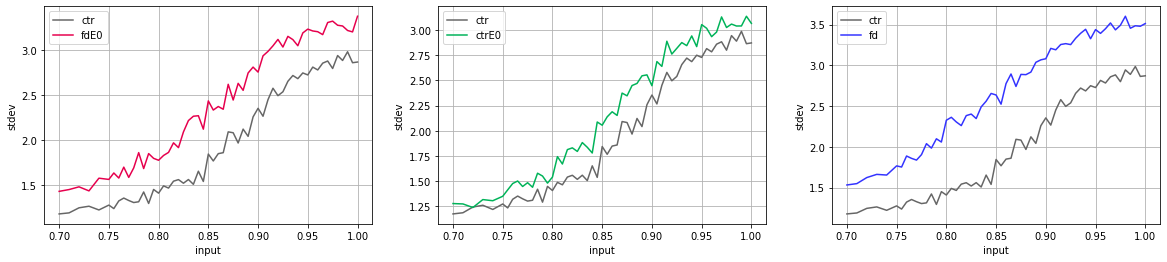

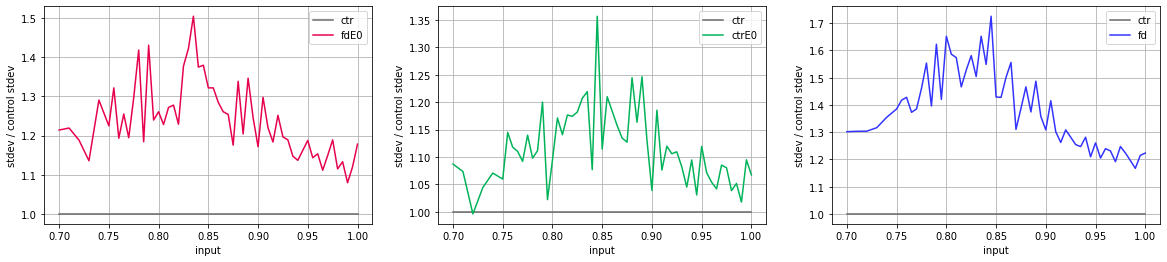

In [42]:
list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd']]
#list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd'], ['ctrE0', 'fd'], ['fdE0', 'fd']]

fig, ax = plt.subplots(nrows=1, ncols=len(list_mplots), figsize=(20,4))


idx = 0
for lm in list_mplots:
    
    for model in lm:

        ax[idx].plot(list_input0, vm_XX_std_models[model], color=palette[model], label=model)
    
    #ax[idx].plot(list_input0, ctr_fresponse, lw=5,color=palette[model], label=model)
    ax[idx].set_xlabel('input')
    ax[idx].set_ylabel('stdev')
    ax[idx].grid()
    ax[idx].legend()
    
    idx +=1
    
    
list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd']]
#list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd'], ['ctrE0', 'fd'], ['fdE0', 'fd']]

fig, ax = plt.subplots(nrows=1, ncols=len(list_mplots), figsize=(20,4))

idx = 0
for lm in list_mplots:
    
    for model in lm:

        ax[idx].plot(list_input0, 
                     [x/y for x,y in zip(vm_XX_std_models[model],vm_XX_std_models['ctr'])], 
                     color=palette[model], label=model)
    
    #ax[idx].plot(list_input0, ctr_fresponse, lw=5,color=palette[model], label=model)
    ax[idx].set_xlabel('input')
    ax[idx].set_ylabel('stdev / control stdev')
    ax[idx].grid()
    ax[idx].legend()
    
    idx +=1
    


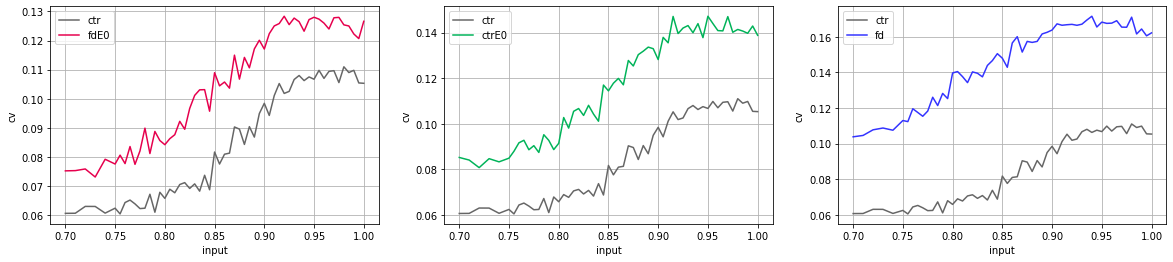

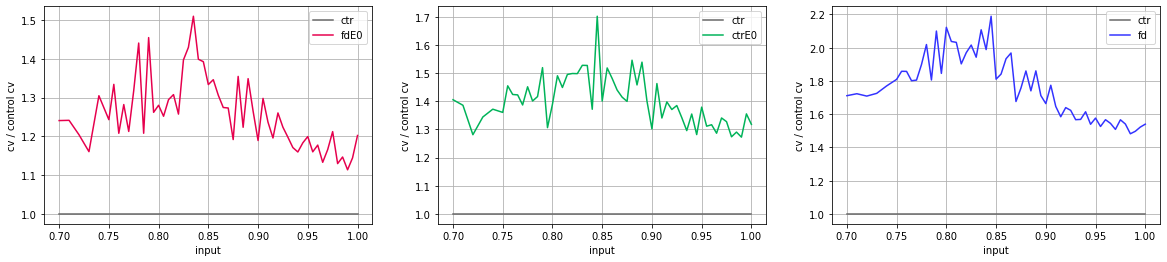

In [17]:
list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd']]
#list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd'], ['ctrE0', 'fd'], ['fdE0', 'fd']]

fig, ax = plt.subplots(nrows=1, ncols=len(list_mplots), figsize=(20,4))


idx = 0
for lm in list_mplots:
    
    for model in lm:

        ax[idx].plot(list_input0, cv_XX_models[model], color=palette[model], label=model)
    
    #ax[idx].plot(list_input0, ctr_fresponse, lw=5,color=palette[model], label=model)
    ax[idx].set_xlabel('input')
    ax[idx].set_ylabel('cv')
    ax[idx].grid()
    ax[idx].legend()
    
    idx +=1
    
    
list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd']]
#list_mplots = [['ctr', 'fdE0'], ['ctr', 'ctrE0'], ['ctr', 'fd'], ['ctrE0', 'fd'], ['fdE0', 'fd']]

fig, ax = plt.subplots(nrows=1, ncols=len(list_mplots), figsize=(20,4))

idx = 0
for lm in list_mplots:
    
    for model in lm:

        ax[idx].plot(list_input0, 
                     [x/y for x,y in zip(cv_XX_models[model],cv_XX_models['ctr'])], 
                     color=palette[model], label=model)
    
    #ax[idx].plot(list_input0, ctr_fresponse, lw=5,color=palette[model], label=model)
    ax[idx].set_xlabel('input')
    ax[idx].set_ylabel('cv / control cv')
    ax[idx].grid()
    ax[idx].legend()
    
    idx +=1

In [43]:
cv_input_range = [0,0.75]
cv_input_range = [0,1]

ctr_avgcv = np.mean([x for x,p in zip(cv_XX_models['ctr'],list_input0) 
                   if p<=cv_input_range[1] and p>=cv_input_range[0]])

for model in cv_XX_models.keys():

    print(model)
    m_avgcv = np.mean([x for x,p in zip(cv_XX_models[model],list_input0) 
                   if p<=cv_input_range[1] and p>=cv_input_range[0]])
    print(m_avgcv/ctr_avgcv)
       

ctr
1.0
fdE0
1.2461042928522208
ctrE0
1.3914930565872832
fd
1.7352210356529043


In [55]:
#cv_input_range = [0.78,0.90]
#cv_input_range = [0,1]
cv_input_range = [0,0.80]
#cv_input_range = [0,0.85]

for model in cv_XX_models.keys():

    print(model)
    #print(np.mean([x/y for x,y in zip(cv_XX_models[model],cv_XX_models['ctr'])]))
    print(np.mean([x/y for x,y,p in zip(cv_XX_models[model],cv_XX_models['ctr'],list_input0) 
                   if p<=cv_input_range[1] and p>=cv_input_range[0]]))
       

ctr
1.0
fdE0
1.2746876485563272
ctrE0
1.394942685028864
fd
1.8476454622608456


# SAVE DATA

In [20]:
import pandas as pd
import os 

In [26]:
path_data = './data'


In [19]:
# I/O data FITTED

"""   
x0 = np.linspace(0.7, 1, num=100, endpoint=True)

datadict = {'input_prheo':list(x0)}   

for model in p_spike_models.keys():
    datadict['pspike_'+model] = list(genlogistic(x0, *popt_io_fit[model]))

df = pd.DataFrame(datadict)  

# saving the dataframe  
file_name = 'io_pspike_deterministic_uncompensated.csv'
df.to_csv(os.path.join(path_data, file_name))  

"""


In [27]:
# TUNING CURVE data

"""   

datadict = {'input_angle':list_theta, 
            'input_prheo': list_inputdata}   

for model in p_spike_models.keys():
    res = genlogistic(np.array(list_inputdata), *popt_io_fit[model])
    datadict['pspikenorm_'+model] = list(res/max(res))
    datadict['fitgausspspikenorm_'+model] = list(gaussprofile_simple(np.array(list_theta),*popt_tc_fit[model]))

df = pd.DataFrame(datadict)  

# saving the dataframe  
file_name = 'tuncurve_data_deterministic_uncompensated.csv'
df.to_csv(os.path.join(path_data, file_name))  

    

"""
